In [26]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
from sklearn.preprocessing import scale

In [10]:
df_hmeq = pd.read_csv("./HMEQ.csv", engine='python')
df_hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [11]:
df_hmeq.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [12]:
df_hmeq["JOB"].fillna("Other",inplace=True)
df_hmeq.fillna(df_hmeq.mean(),inplace=True)

In [13]:
np.random.seed(seed=1234)
msk = np.random.rand(df_hmeq.shape[0],) < 0.7
df_hmeq_train = df_hmeq[msk]
df_hmeq_test = df_hmeq[~msk]

print("train_data_size:",df_hmeq_train.shape)
print("test_data_size:",df_hmeq_test.shape)

train_data_size: (2604, 13)
test_data_size: (1144, 13)


---

In [14]:
df_hmeq_const_train = sm.add_constant(df_hmeq_train)
df_hmeq_const_train.head()

,const,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1.0,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,1.0,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
5,1.0,0,2900,103949,112505.0,HomeImp,Office,1.0,0,0.0,96.102330,0.0,13,30.051136
6,1.0,0,2900,104373,120702.0,HomeImp,Office,2.0,0,0.0,101.540297,0.0,13,29.915859


In [15]:
log_model = sm.Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ +
                                  DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC + 1""", df_hmeq_const_train)
log_res = log_model.fit()
print(log_res.summary())

Optimization terminated successfully.
         Current function value: 0.244454
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2604
Model:                          Logit   Df Residuals:                     2587
Method:                           MLE   Df Model:                           16
Date:                Fri, 01 Feb 2019   Pseudo R-squ.:                  0.2096
Time:                        10:14:35   Log-Likelihood:                -636.56
converged:                       True   LL-Null:                       -805.35
                                        LLR p-value:                 4.004e-62
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.7741      0.518     -9.209      0.000      -5.790      -3.758

In [17]:
df_hmeq_const_train.shape

(2604, 14)

In [21]:
y_pred = log_res.predict(df_hmeq_test)
y_pred_class = (y_pred >0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

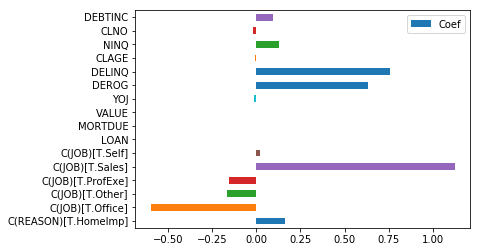

In [24]:
df_logistic_coef = pd.DataFrame({"Coef":log_res.params.values[1:]}, index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

In [27]:
df_hmeq_char = df_hmeq.select_dtypes(include="object")
df_hmeq_numeric = df_hmeq.select_dtypes(exclude="object")

df_hmeq_char_train = df_hmeq_char[msk]
df_hmeq_numeric_scaled_train = scale(df_hmeq_numeric[msk])
df_hmeq_numeric_scaled_train = pd.DataFrame(df_hmeq_numeric_scaled_train, columns=df_hmeq_numeric.columns)
df_hmeq_numeric_scaled_train.head()

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,3.124153,-1.546445,-0.994709,-1.227453,-0.020546,-0.26517,-0.337599,-0.962571,-0.019984,-1.424138,0.372555
1,3.124153,-1.537818,-1.040082,-1.177823,0.250021,-0.26517,-0.337599,-1.117329,-0.663021,-1.424138,0.344145
2,-0.320087,-1.494683,0.598052,0.247041,-0.967531,-0.26517,-0.337599,-1.090197,-0.663021,-0.898712,-0.313747
3,-0.320087,-1.442920,0.633069,0.092557,-1.102815,-0.26517,-0.337599,-1.027931,-0.663021,-0.898712,-0.504711
4,-0.320087,-1.442920,0.642472,0.242451,-0.967531,-0.26517,-0.337599,-0.961666,-0.663021,-0.898712,-0.521514


In [30]:
df_hmeq_numeric_scaled_train["BAD"] = np.where(df_hmeq_numeric_scaled_train["BAD"]>0,1,0)
df_hmeq_numeric_scaled_train.head()

df_hmeq_scaled_train = pd.concat([df_hmeq_numeric_scaled_train, df_hmeq_char_train.reset_index(drop=True)],axis=1)

Optimization terminated successfully.
         Current function value: 0.244454
         Iterations 7


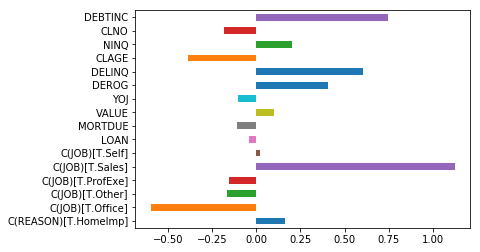

In [31]:
scaled_log_model = sm.Logit.from_formula("""BAD~LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+
                                            DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC+1""",df_hmeq_scaled_train)
scaled_log_res = scaled_log_model.fit()
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_res.params.values[1:]}, index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef",legend=False)

---

In [19]:
df_hmeq_train.shape

(2604, 13)

In [32]:
log_model = sm.Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ +
                                  DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC""", df_hmeq_train)
log_res = log_model.fit()
print(log_res.summary())

Optimization terminated successfully.
         Current function value: 0.244454
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2604
Model:                          Logit   Df Residuals:                     2587
Method:                           MLE   Df Model:                           16
Date:                Fri, 01 Feb 2019   Pseudo R-squ.:                  0.2096
Time:                        10:42:09   Log-Likelihood:                -636.56
converged:                       True   LL-Null:                       -805.35
                                        LLR p-value:                 4.004e-62
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.7741      0.518     -9.209      0.000      -5.790      -3.758

In [33]:
# log_model = sm.Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB) + YOJ +
#                                   DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC + 1""", df_hmeq_train)
# log_res = log_model.fit()
# print(log_res.summary())

In [34]:
y_pred = log_res.predict(df_hmeq_test)
y_pred_class = (y_pred >0.5).astype(int)
y_pred_class.head()

3    0
4    0
7    0
8    0
9    0
dtype: int64

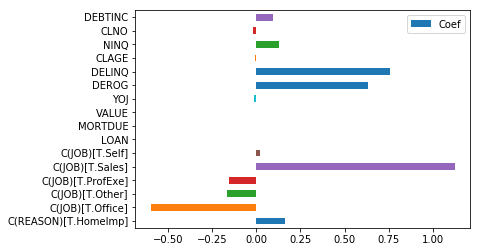

In [35]:
df_logistic_coef = pd.DataFrame({"Coef":log_res.params.values[1:]}, index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

In [36]:
df_hmeq_char = df_hmeq.select_dtypes(include="object")
df_hmeq_numeric = df_hmeq.select_dtypes(exclude="object")

df_hmeq_char_train = df_hmeq_char[msk]
df_hmeq_numeric_scaled_train = scale(df_hmeq_numeric[msk])
df_hmeq_numeric_scaled_train = pd.DataFrame(df_hmeq_numeric_scaled_train, columns=df_hmeq_numeric.columns)
df_hmeq_numeric_scaled_train.head()

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,3.124153,-1.546445,-0.994709,-1.227453,-0.020546,-0.26517,-0.337599,-0.962571,-0.019984,-1.424138,0.372555
1,3.124153,-1.537818,-1.040082,-1.177823,0.250021,-0.26517,-0.337599,-1.117329,-0.663021,-1.424138,0.344145
2,-0.320087,-1.494683,0.598052,0.247041,-0.967531,-0.26517,-0.337599,-1.090197,-0.663021,-0.898712,-0.313747
3,-0.320087,-1.442920,0.633069,0.092557,-1.102815,-0.26517,-0.337599,-1.027931,-0.663021,-0.898712,-0.504711
4,-0.320087,-1.442920,0.642472,0.242451,-0.967531,-0.26517,-0.337599,-0.961666,-0.663021,-0.898712,-0.521514


In [37]:
df_hmeq_numeric_scaled_train["BAD"] = np.where(df_hmeq_numeric_scaled_train["BAD"]>0,1,0)
df_hmeq_numeric_scaled_train.head()

df_hmeq_scaled_train = pd.concat([df_hmeq_numeric_scaled_train, df_hmeq_char_train.reset_index(drop=True)],axis=1)

Optimization terminated successfully.
         Current function value: 0.244454
         Iterations 7


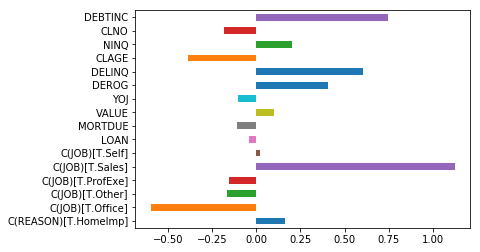

In [38]:
scaled_log_model = sm.Logit.from_formula("""BAD~LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+
                                            DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC""",df_hmeq_scaled_train)
scaled_log_res = scaled_log_model.fit()
df_log_scaled_coef = pd.DataFrame({"Coef":scaled_log_res.params.values[1:]}, index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef",legend=False)